In [7]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
baseline_df = pd.read_csv('../../out/csv/baseline_metrics.csv')

t5_df = pd.read_csv('../../out/csv/t5-base_metrics_4.csv')
t5_df['model'] = 't5-base'
t5_df.rename(columns={'week': 'ds'}, inplace=True)

df = pd.concat([baseline_df, t5_df])
df['ds'] = pd.to_datetime(df['ds']).dt.date
df = df[df['ds'] >= pd.to_datetime('2023-05-07').date()]

df

,ds,accuracy,precision,recall,f1,model
0,2023-05-07,0.608696,0.608696,1.000000,0.756757,MLP
1,2023-05-14,0.615942,0.534653,0.900000,0.670807,MLP
2,2023-05-21,0.710145,0.773810,0.755814,0.764706,MLP
3,2023-05-28,0.665049,0.863636,0.487179,0.622951,MLP
4,2023-06-04,0.625000,0.643939,0.620438,0.631970,MLP
...,...,...,...,...,...,...
16,2023-08-20,0.813472,0.700000,0.490000,0.576471,t5-base
17,2023-08-27,0.824742,0.829268,0.557377,0.666667,t5-base
18,2023-09-03,0.791237,0.837838,0.596154,0.696629,t5-base
19,2023-09-10,0.841026,0.796992,0.751773,0.773723,t5-base


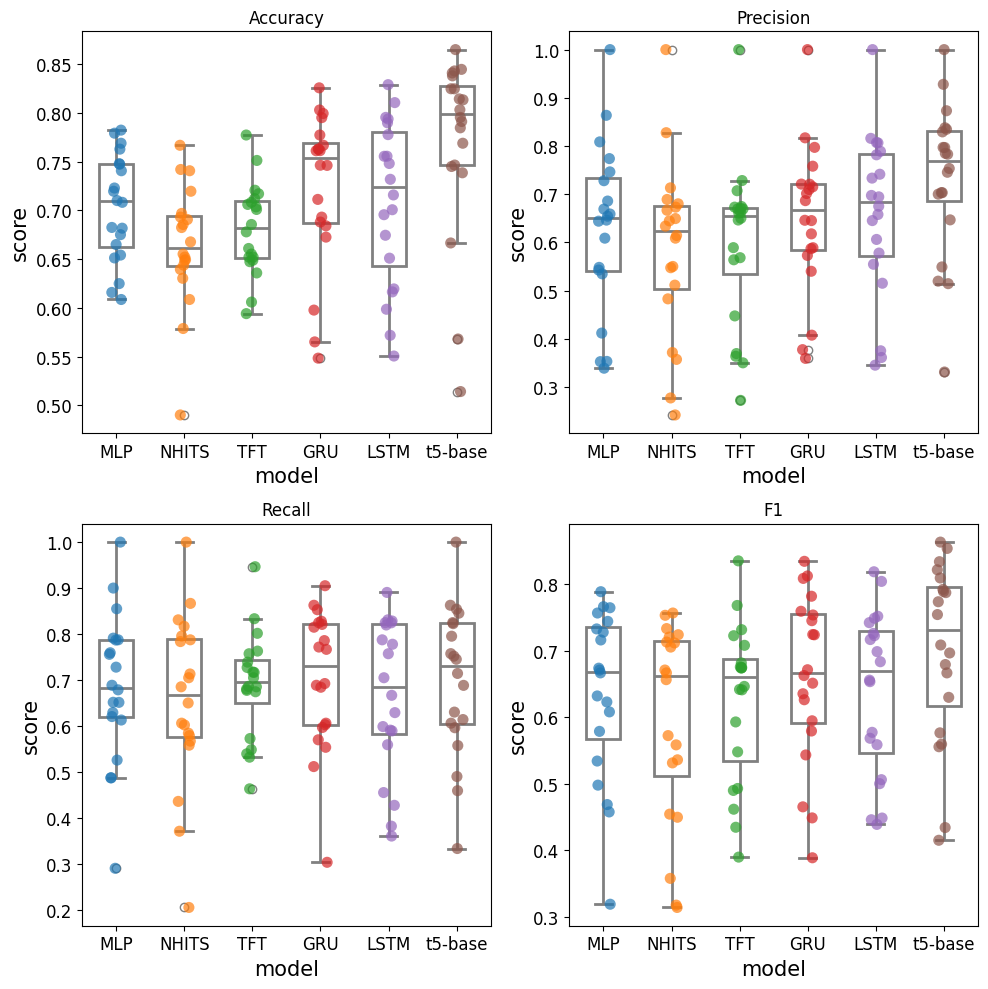

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

box_args = {
    'data': df,
    'x': 'model',
    'hue': 'model',
    'palette': df['model'].unique().size * ['white'],
    'linewidth': 2,
    'linecolor': 'grey',
    'width': 0.5,
}

strip_args = {
    'data': df,
    'x': 'model',
    'hue': 'model',
    'size': 8,
}

for m, ax in zip(['accuracy', 'precision', 'recall', 'f1'], axs.flatten()):
    sns.boxplot(**box_args, y=m, ax=ax)
    sns.stripplot(**strip_args, y=m, ax=ax, alpha=0.7)
    ax.set_title(m.capitalize())
    ax.set_ylabel('score', fontsize=15)
    ax.set_xlabel('model', fontsize=15)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

fig.tight_layout()
fig.savefig('../../out/img/metrics_t5-base_vs_baseline.pdf')

In [10]:
describe = df.groupby('model').describe(percentiles=[.5]).T
describe.drop(index=['count', 'min', 'max'], level=1, inplace=True)


def highlight_max(s):
    d = s.sort_values(ascending=False)

    style = {
        d.index[0]: 'textbf:--rwrap ;',   # max
        d.index[1]: 'underline:--rwrap ;',  # second max
        d.index[-1]: 'textit:--rwrap ;',  # min
    }

    return [style.get(v, '') for v in s.index]


describe.style.apply(highlight_max, axis=1).format('{:.3f}').format_index(escape='latex').to_latex(
    '../../out/tex/metrics_by_model.tex', hrules=True, caption='Metrics by model (T5-base with 4 weeks of prompt data vs baseline)', label='tab:metrics_by_model', clines='skip-last;data')

describe.style.apply(highlight_max, axis=1).format('{:.3f}')

In [11]:
ranks = describe.rank(axis=1, method='min', ascending=False)

# Fixing the ranks of the std metrics (lower is better)
ranks[ranks.index.get_level_values(1) == 'std'] = ranks[ranks.index.get_level_values(
    1) == 'std'].rank(axis=1, method='min', ascending=False)

ranks.mean().sort_values()

model
t5-base    2.166667
GRU        2.500000
LSTM       3.333333
TFT        3.500000
MLP        3.833333
NHITS      5.666667
dtype: float64

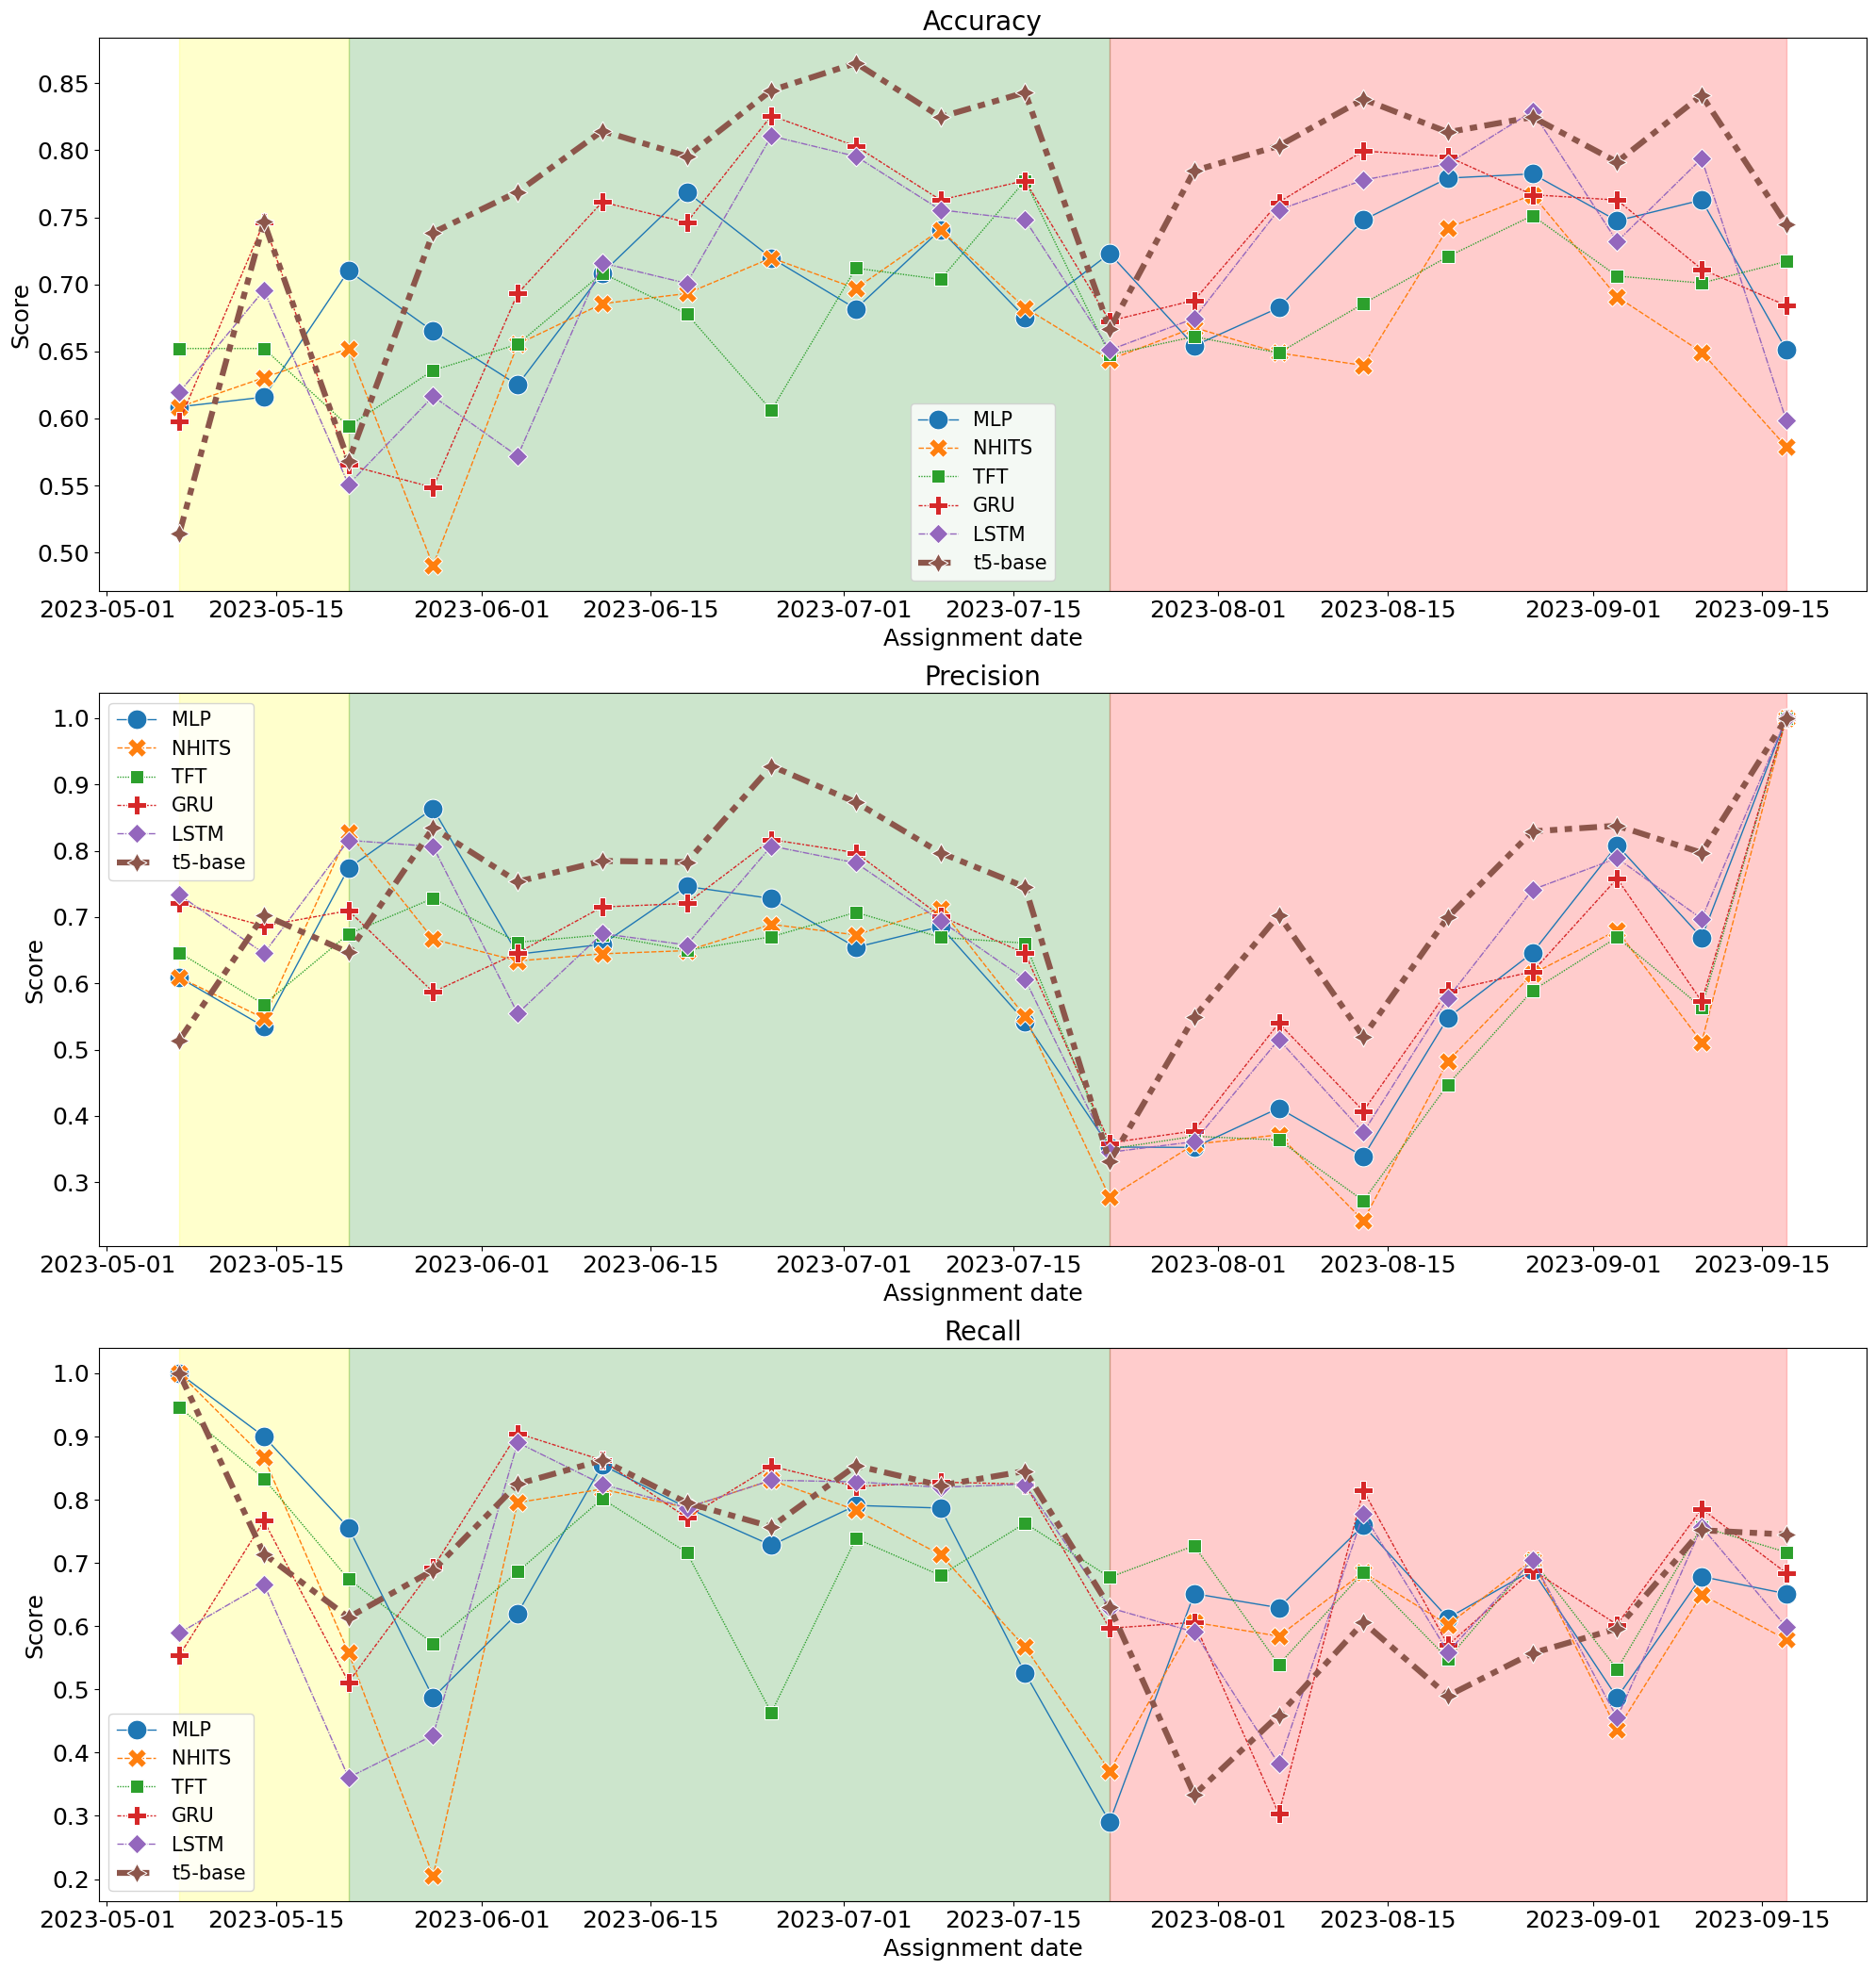

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(20, 21))
sizes = {
    't5-base': 4.5,
    'GRU': 1,
    'LSTM': 1,
    'TFT': 1,
    'MLP': 1,
    'NHITS': 1,
}

for metric, ax in zip(['accuracy', 'precision', 'recall'], axs.flatten()):
    sns.lineplot(data=df, x='ds', y=metric, hue='model', ax=ax,
                 style='model', markers=True, markersize=15, size='model', sizes=sizes)
    ax.legend(fontsize=15)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title(metric.capitalize(), fontsize=20)
    ax.set_ylabel('Score', fontsize=18)
    ax.set_xlabel('Assignment date', fontsize=18)
    ax.axvspan('2023-05-07', '2023-05-21', color='yellow', alpha=0.2)
    ax.axvspan('2023-05-21', '2023-07-23', color='green', alpha=0.2)
    ax.axvspan('2023-07-23', '2023-09-17', color='red', alpha=0.2)

fig.tight_layout()
fig.savefig('../../out/img/metrics_by_week.pdf', bbox_inches='tight')